In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import re
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string
import time


nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df1=pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json",lines=True)
df1=df1[['headline','is_sarcastic']]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [ ]:
df=df1.drop(df1[df1['is_sarcastic']==1].sample(frac=0.10).index)
df=df.reset_index()

In [ ]:
df.head()

,index,headline,is_sarcastic
0,0,thirtysomething scientists unveil doomsday clock of hair loss,1
1,1,"dem rep. totally nails why congress is falling short on gender, racial equality",0
2,2,eat your veggies: 9 deliciously different recipes,0
3,3,inclement weather prevents liar from getting to work,1
4,5,my white inheritance,0


In [ ]:
df.index

RangeIndex(start=0, stop=27256, step=1)

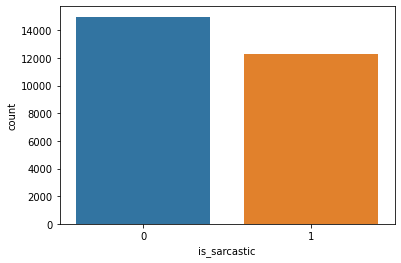

In [ ]:
sns.countplot(data=df,x=df.is_sarcastic);

In [ ]:
pd.options.display.max_colwidth = 200
pd.DataFrame(df[df['is_sarcastic']==1]['headline']).head(10)

,headline
0,thirtysomething scientists unveil doomsday clock of hair loss
3,inclement weather prevents liar from getting to work
6,richard branson's global-warming donation nearly as much as cost of failed balloon trips
7,shadow government getting too large to meet in marriott conference room b
13,ford develops new suv that runs purely on gasoline
15,area boy enters jumping-and-touching-tops-of-doorways phase
16,area man does most of his traveling by gurney
20,guard in video game under strict orders to repeatedly pace same stretch of hallway
24,secret service agent not so secret about being david alan grier fan
32,leading probability researchers confounded by three coworkers wearing same shirt color on same day


In [ ]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s$", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
stopwords_english = set(stopwords.words('english'))-set(['No','no','not','Not'])
def preprocess(text,stopwords=stopwords_english):
    lemmatizer = WordNetLemmatizer()


    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    #Decontract texts
    text=decontract(text)
    # tokenize texts


    texts_clean = []
    for word in text.split():
        if (word not in stopwords_english and  # remove stopwords
                word not in set(string.punctuation)-set(['!','?','.','@',':'])):  # remove punctuation
            #Lemmatize word 
            lem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(lem_word)

    return " ".join(texts_clean)

In [ ]:
inputs=list(df['headline'].apply(lambda x: preprocess(x)))
labels=list(df['is_sarcastic'])
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2)


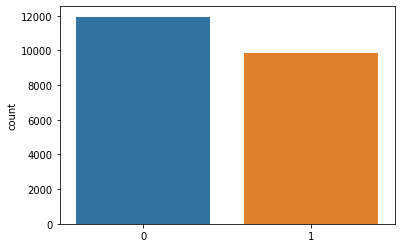

In [ ]:
sns.countplot(x=y_train);

In [ ]:
def subword_tokenize(train_corpus, vocab_size=2**14, max_length=50,tokenizer=None):
  # Create the vocabulary using Subword tokenization
  if(tokenizer==None):
    tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_corpus, target_vocab_size=2**14)
  else:
    tokenizer_corpus=tokenizer
  # Get the final vocab size, adding the eos and sos tokens
  vocab_size = tokenizer_corpus.vocab_size 
  
  # Tokenize the corpus
  sentences = [tokenizer_corpus.encode(sentence) for sentence in train_corpus]

  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,value=0,padding='post',maxlen=50)
  
  return sentences, tokenizer_corpus, vocab_size

In [ ]:
tokenized_inputs,tokenizer,vocab_size=subword_tokenize(train_corpus=X_train)
tokenized_test_inputs,_,vocab_size2=subword_tokenize(X_test,tokenizer=tokenizer)

In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices((tokenized_inputs, y_train))
dataset = dataset.shuffle(len(tokenized_inputs), reshuffle_each_iteration=True).batch(128, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

In [ ]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
        self.last_linear = layers.Dense(units=2, name="lin_ouput")
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        logits=tf.math.reduce_mean(outputs,1)
        #print(logits.shape)


        logits=self.last_linear(logits)

        return logits #outputs[:,0:1,:]

In [ ]:
def create_padding_mask(seq): #seq: (batch_size, seq_length)
# Create the mask for padding
  mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]
def loss_function(target, pred):

    
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(target,pred)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def main_train(dataset, encoder, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        #dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        targets = pd.get_dummies(targets).astype('float').values
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = encoder(inputs, create_padding_mask(inputs), True)
            # Calculate the loss
            loss = loss_function(targets, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, encoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
       
        train_accuracy(targets, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    # Checkpoint the model on every epoch        
    #ckpt_save_path = ckpt_manager.save()
    #print("Saving checkpoint for epoch {} in {}".format(epoch+1,ckpt_save_path))
    #print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

In [ ]:
tf.keras.backend.clear_session()
# Create the Encoder model
encoder = Encoder(6,512,8,0.1,vocab_size,256)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
losses, accuracies = main_train(dataset, encoder, 5)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.2113 Accuracy 0.9023
Epoch 1 Batch 50 Loss 0.2162 Accuracy 0.9082
Epoch 1 Batch 100 Loss 0.2226 Accuracy 0.9069
Epoch 1 Batch 150 Loss 0.2366 Accuracy 0.9001


In [ ]:
def predict(encoder,tokenized_sentences):
  logits=encoder(tokenized_sentences,create_padding_mask(tokenized_sentences),False)
  predictions=np.argmax(tf.keras.layers.Softmax()(logits),axis=1)
  return predictions
test_accuracy=sum((predict(encoder,tokenized_test_inputs)==y_test))
test_accuracy/=len(y_test)
print(test_accuracy)
from sklearn.metrics import classification_report
print(classification_report(predict(encoder,tokenized_test_inputs),y_test))

0.8209831254585473
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3355
           1       0.73      0.84      0.78      2097

    accuracy                           0.82      5452
   macro avg       0.81      0.82      0.82      5452
weighted avg       0.83      0.82      0.82      5452



In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder_lstm"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
        self.lstm=layers.LSTM(128)
        self.last_linear = layers.Dense(units=2, name="lin_ouput")
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        #logits=tf.math.reduce_mean(outputs,1)
        #print(logits.shape)
        logits=self.lstm(outputs)


        logits=self.last_linear(logits)

        return logits #outputs[:,0:1,:]


tf.keras.backend.clear_session()
# Create the Encoder model
encoder_lstm = Encoder(6,512,8,0.1,vocab_size,256)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

losses, accuracies = main_train(dataset, encoder_lstm, 5)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.7143 Accuracy 0.5352
Epoch 1 Batch 50 Loss 0.7004 Accuracy 0.5061
Epoch 1 Batch 100 Loss 0.6891 Accuracy 0.5120
Epoch 1 Batch 150 Loss 0.6787 Accuracy 0.5324
Starting epoch 2
Epoch 2 Batch 0 Loss 0.6344 Accuracy 0.6328
Epoch 2 Batch 50 Loss 0.6047 Accuracy 0.6505
Epoch 2 Batch 100 Loss 0.5814 Accuracy 0.6748
Epoch 2 Batch 150 Loss 0.5666 Accuracy 0.6892
Starting epoch 3
Epoch 3 Batch 0 Loss 0.4442 Accuracy 0.7930
Epoch 3 Batch 50 Loss 0.4346 Accuracy 0.7864
Epoch 3 Batch 100 Loss 0.4285 Accuracy 0.7910
Epoch 3 Batch 150 Loss 0.4217 Accuracy 0.7956
Starting epoch 4
Epoch 4 Batch 0 Loss 0.2713 Accuracy 0.8867
Epoch 4 Batch 50 Loss 0.2964 Accuracy 0.8670
Epoch 4 Batch 100 Loss 0.3145 Accuracy 0.8581
Epoch 4 Batch 150 Loss 0.3152 Accuracy 0.8581
Starting epoch 5
Epoch 5 Batch 0 Loss 0.2847 Accuracy 0.8789
Epoch 5 Batch 50 Loss 0.2055 Accuracy 0.9154
Epoch 5 Batch 100 Loss 0.2164 Accuracy 0.9115
Epoch 5 Batch 150 Loss 0.2303 Accuracy 0.9048


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predict(encoder_lstm,tokenized_test_inputs),y_test))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      2791
           1       0.84      0.76      0.80      2661

    accuracy                           0.81      5452
   macro avg       0.82      0.81      0.81      5452
weighted avg       0.82      0.81      0.81      5452



In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder_cnn"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
        self.cnn=layers.Conv2D(1, (3,3), activation='relu', padding='same', input_shape=(50,256,1))
        self.flatten=layers.Flatten()
        self.last_linear = layers.Dense(units=2, name="lin_ouput")
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        #logits=tf.math.reduce_mean(outputs,1)
        #print(logits.shape)
        logits=K.expand_dims(outputs,axis=-1)
        logits=self.cnn(logits)
        logits=self.flatten(logits)


        logits=self.last_linear(logits)

        return logits #outputs[:,0:1,:]
tf.keras.backend.clear_session()
# Create the Encoder model
encoder_cnn = Encoder(6,512,8,0.1,vocab_size,256)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
losses, accuracies = main_train(dataset, encoder_cnn, 4)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.7173 Accuracy 0.5391
Epoch 1 Batch 50 Loss 0.7090 Accuracy 0.5152
Epoch 1 Batch 100 Loss 0.7032 Accuracy 0.5186
Epoch 1 Batch 150 Loss 0.6961 Accuracy 0.5265
Starting epoch 2
Epoch 2 Batch 0 Loss 0.7001 Accuracy 0.5430
Epoch 2 Batch 50 Loss 0.6269 Accuracy 0.6208
Epoch 2 Batch 100 Loss 0.6051 Accuracy 0.6480
Epoch 2 Batch 150 Loss 0.5839 Accuracy 0.6701
Starting epoch 3
Epoch 3 Batch 0 Loss 0.5502 Accuracy 0.7109
Epoch 3 Batch 50 Loss 0.4502 Accuracy 0.7803
Epoch 3 Batch 100 Loss 0.4439 Accuracy 0.7836
Epoch 3 Batch 150 Loss 0.4417 Accuracy 0.7830
Starting epoch 4
Epoch 4 Batch 0 Loss 0.2956 Accuracy 0.8594
Epoch 4 Batch 50 Loss 0.3158 Accuracy 0.8582
Epoch 4 Batch 100 Loss 0.3270 Accuracy 0.8554
Epoch 4 Batch 150 Loss 0.3245 Accuracy 0.8566


In [ ]:
losses, accuracies = main_train(dataset, encoder_cnn, 1)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.2595 Accuracy 0.8867
Epoch 1 Batch 50 Loss 0.2479 Accuracy 0.8938
Epoch 1 Batch 100 Loss 0.2385 Accuracy 0.8969
Epoch 1 Batch 150 Loss 0.2489 Accuracy 0.8948


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predict(encoder_cnn,tokenized_test_inputs),y_test))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3117
           1       0.78      0.80      0.79      2335

    accuracy                           0.82      5452
   macro avg       0.82      0.82      0.82      5452
weighted avg       0.82      0.82      0.82      5452



In [ ]:
examples=['Woman wins award for safe driving','I work forty hours a week for me to be this poor.','I would kill for a Nobel Peace Prize.','Depression is merely anger without enthusiasm.','Two wrongs don’t make a right take your parents as an example .','If I wanted to kill myself I’d climb your ego and jump to your IQ.','Always remember that you are absolutely unique just like everyone else .','Congratulations, If you press the elevator button three times it goes into hurry mode – really...','Hello my name is Raj and I study computer science!','Please get me some fruits from the store .','Want to hang out today ?','Presidency is probably the toughest job around','We should go out and play football','Discounted items end up being the most expensive']

In [ ]:
example="Trump's tenure oversaw a massive economic decline , definitely going to vote for him again ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(encoder,sentence))

Trump's tenure oversaw a massive economic decline , definitely going to vote for him again .
[1]


In [ ]:
example="Today is such a beautiful day , the weather is perfect to stay inside ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(encoder,sentence))

Today is such a beautiful day , the weather is perfect to stay inside .
[1]


In [ ]:
#example='Woman wins award for safe driving'
for example in examples:
  sentence=tokenizer.encode(preprocess(example))
  sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
  print(example)
  print(predict(encoder,sentence))
  print(predict(encoder_lstm,sentence))
  print(predict(encoder_cnn,sentence))

Woman wins award for safe driving
[0]
[0]
[0]
I work forty hours a week for me to be this poor.
[1]
[1]
[1]
I would kill for a Nobel Peace Prize.
[0]
[0]
[0]
Depression is merely anger without enthusiasm.
[1]
[1]
[0]
Two wrongs don’t make a right take your parents as an example .
[0]
[0]
[0]
If I wanted to kill myself I’d climb your ego and jump to your IQ.
[1]
[0]
[0]
Always remember that you are absolutely unique just like everyone else .
[0]
[1]
[0]
Congratulations, If you press the elevator button three times it goes into hurry mode – really...
[1]
[1]
[1]
Hello my name is Raj and I study computer science!
[0]
[0]
[1]
Please get me some fruits from the store .
[1]
[1]
[1]
Want to hang out today ?
[0]
[0]
[0]
Presidency is probably the toughest job around
[1]
[0]
[1]
We should go out and play football
[0]
[1]
[0]
Discounted items end up being the most expensive
[1]
[1]
[1]


In [ ]:
import os
checkpoint_folder = "ckpt/"
checkpoint_path = os.path.abspath(os.path.join('', checkpoint_folder))

In [ ]:
checkpoint_path

'/content/ckpt'

In [ ]:
ckpt = tf.train.Checkpoint(encoder=encoder,optimizer=optimizer,)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [ ]:
ckpt_save_path = ckpt_manager.save()

In [ ]:
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

Last checkpoint restored.


In [ ]:
print(roc_auc_score(y_test, predict_proba2(encoder,tokenized_test_inputs)[:, 1]))


0.9047049028952252


In [ ]:
encoder=Encoder()

In [ ]:
def predict_proba2(encoder,examples):
    #sentences=[tokenizer.encode(example) for example in examples]
    #sentences=tf.keras.preprocessing.sequence.pad_sequences(sentences,value=0,padding='post',maxlen=50)
    logits=encoder(examples,create_padding_mask(examples),False)
    return layers.Softmax()(logits).numpy()




In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, predict_proba2(encoder,tokenized_test_inputs)[:, 1]))
print(roc_auc_score(y_test, predict_proba2(encoder_lstm,tokenized_test_inputs)[:, 1]))
print(roc_auc_score(y_test, predict_proba2(encoder_cnn,tokenized_test_inputs)[:, 1]))

0.9047049028952252
0.9028470707734592
0.902234841493594


In [ ]:
print(roc_auc_score(y_test, predict_proba2(encoder_cnn,tokenized_test_inputs)[:, 1]))


0.5286365388734204
